<h1>🎓 Trabajo Integrador Final - Laboratorio de Ciencias de Datos</h1>

<h2>👥 Integrantes</h2>
<ul>
  <li>Fernando Burgos</li>
  <li>Francisco Garcia</li>
  <li>Evers Juan Segundo</li>
  <li>Kelechian Leonardo</li>
</ul>

# ✨ Introducción

En el presente trabajo desarrollaremos un proyecto completo de análisis y modelado predictivo sobre el abandono de clientes (“churn”) en una compañía de telecomunicaciones. Dado que adquirir un nuevo cliente puede ser bastante más costoso que retener a uno existente, contar con una predicción fiable de churn se traduce en un importante beneficio tanto económico como de satisfacción para la compañía.


El dataset consta de 7 043 observaciones y 21 variables que describen información demográfica (género, edad, estado de pareja, dependientes), datos de la cuenta (tiempo de permanencia, tipo de contrato, método de pago, facturación sin papel), cargos monetarios (cargos mensuales y totales) y servicios contratados (telefonía, múltiples líneas, Internet y servicios asociados como seguridad en línea, copias de respaldo, soporte técnico o streaming).

La variable respuesta `Churn` indica si el cliente canceló su contrato en el último mes. Siguiendo la metodología del ciclo de vida de un proyecto propuesta en la asignatura, incluiremos identificación del problema, limpieza de datos, exploración y visualización, selección y ajuste del modelo y finalmente una evaluación del modelo.

<h3>Importamos las librerias que usaremos durante el proyecto</h3>

In [ ]:
# Conexión con Google Drive
# ==============================================================================
# from google.colab import drive
# import os

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import pickle

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis Estadísticos
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')
import math

# PreProcesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score

<h3>Conectamos Google Drive y cargamos el dataset</h3>

In [ ]:
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # elegir la carpeta donde estan las bases de datos:
# ruta_base = "/content/drive/MyDrive/"
# ruta_laboratorio = os.path.join(ruta_base, "Laboratorio de Ciencia de Datos")
# ruta_bases_datos = os.path.join(ruta_laboratorio, "Bases de Datos")

# # elegir la base de datos que quiero usar:
# ruta_archivo = os.path.join(ruta_bases_datos, "Grupo 3 - Abandono de Clientes.csv")
ruta_archivo = "data/Grupo 3 - Abandono de Clientes.csv"

In [ ]:
#Cargar el dataset
data = pd.read_csv(ruta_archivo, sep=',', encoding='utf-8')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Hacemos una primera vista a nuestros datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 💡 Identificar la problemática a resolver

Reconocemos que reducir el churn es crítico: captar un nuevo cliente [puede costar de cinco a veinticinco veces más que retener uno existente](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers). Por ello, nuestro objetivo es predecir con antelación qué usuarios tienen mayor probabilidad de cancelar el servicio.

Un modelo predictivo de churn permite identificar a aquellos clientes con alta probabilidad de abandono y aplicarles de manera selectiva acciones de retención (ofertas personalizadas, upgrades de servicio, atención proactiva), cuya inversión es considerablemente más baja que la necesaria para reemplazarlos por nuevos usuarios. Esto no solo incrementa la eficiencia del presupuesto de marketing, sino que fortalece las métricas de satisfacción y de lealtad, alimentando un círculo virtuoso de crecimiento sostenible.

#⚙️ Preparación de los datos

<b><h3>Limpieza de datos<h3>

Antes de arrancar, tenemos que corroborar que los datos se encuentren limpios de forma tal que no afecten negativamente al modelo.

Luego de realizar un pequeño análisis univariado a las columnas de nuestro data set, encontramos que la columna TotalCharges era de tipo object cuando esta debería ser float. Entonces, la casteamos y encontramos también que escondía un par de valores nulos.

In [ ]:
# Creamos una copia del DataFrame para no modificar el original
df_mod = data.copy()

# Convertimos TotalCharges a tipo numérico (float) y manejar errores
df_mod['TotalCharges'] = pd.to_numeric(df_mod['TotalCharges'], errors='coerce')

# Revisamos valores faltantes o nulos en TotalCharges
print(f"Cantidad de filas con valor nulo en 'Total Charges': {df_mod['TotalCharges'].isnull().sum()}");


Cantidad de filas con valor nulo en 'Total Charges': 11


Como podemos observar, existen 11 filas con valor nulo en esta variable de un total de 7043 registros (aproximadamente 0.16% del dataset). Dado que este porcentaje es mínimo y no representa una pérdida significativa de información, decidimos eliminar directamente estas filas para mantener la integridad del análisis.

In [ ]:
# Eliminamos las filas con valores nulos en TotalCharges
df_mod = df_mod.dropna(subset=['TotalCharges'])
print(f"Cantidad de filas después de eliminar nulos: {len(df_mod)}")
print(f"Filas eliminadas: {len(data) - len(df_mod)}")

Cantidad de filas después de eliminar nulos: 7032
Filas eliminadas: 11


Ahora, la variable TotalCharges ya se encuentra en el tipo de dato correcto y sin valores nulos. El resto de las variables del dataset no requieren ningún cambio de tipo de dato, limpieza o tratamiento de outliers, por lo que podemos proceder con el análisis.

<h1> Limpieza para la visualización</h1>

Para una correcta visualización de los datos tenemos que editar las etiquetas de la variable PaymentMethod.

In [ ]:
df_mod.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [ ]:
df_mod['PaymentMethod'] = df_mod['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

In [ ]:
df_mod.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

---


#📊 EDA

En el análisis exploratorio de datos buscamos analizar las características principales del dataset a través de métodos de visualización y estadísticos de resúmen.
El objetivo es lograr comprender cómo se comportan nuestros datos y descubrir patrones y posibles relaciones entre características y la tasa de churn.

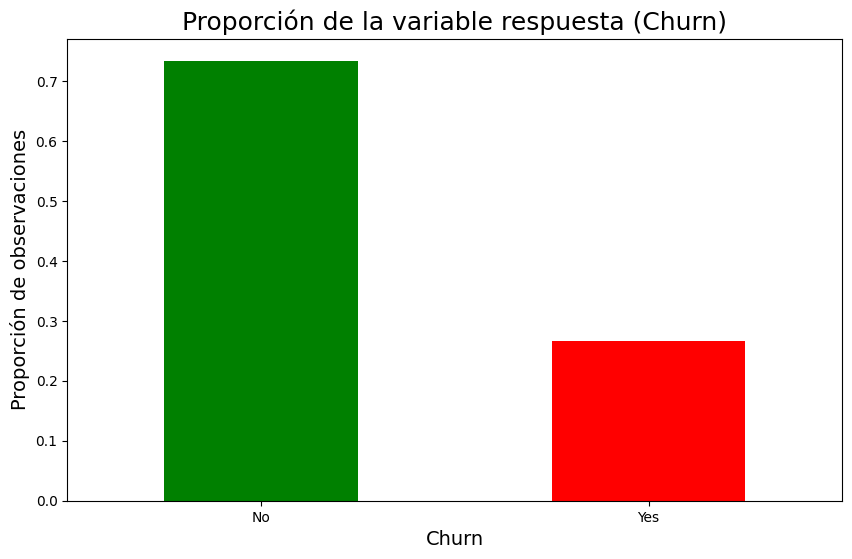

In [ ]:
df_eda = df_mod.copy()

# Creamos la figura
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Proporción de observaciones de cada clase
prop_churn = df_eda['Churn'].value_counts(normalize=True)

# Creamos un barplot mostrando la proporción de Churn
prop_churn.plot(kind='bar',
                   ax=ax,
                   color=['green','red'])

# Titulo y titulos de ejes
ax.set_title('Proporción de la variable respuesta (Churn)',
             fontsize=18)
ax.set_xlabel('Churn',
              fontsize=14)
ax.set_ylabel('Proporción de observaciones',
              fontsize=14)
ax.tick_params(rotation='auto')

<h1>Información demográfica</h1>

A continuación analizaremos las variables de atributos demográficos (`gender`, `SeniorCitizen`, `Partner`, `Dependents`), mostrando la proporción de `Churn` para cada categoría de cada atributo.

In [ ]:
def percentage_stacked_plot(columns_to_plot, super_title):

    '''
    Muestra una barra apilada del 100% de la respuesta variable para cada variable de la lista columns_to_plot.
            Parametros:
                    columns_to_plot (list of string): Nombres de las variables a graficar
                    super_title (string): Titulo general del gráfico
            Returns:
                    None
    '''

    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    fig.suptitle(super_title, fontsize=22,  y=.95)


    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_eda[column], df_eda['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proporción de observaciones en ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

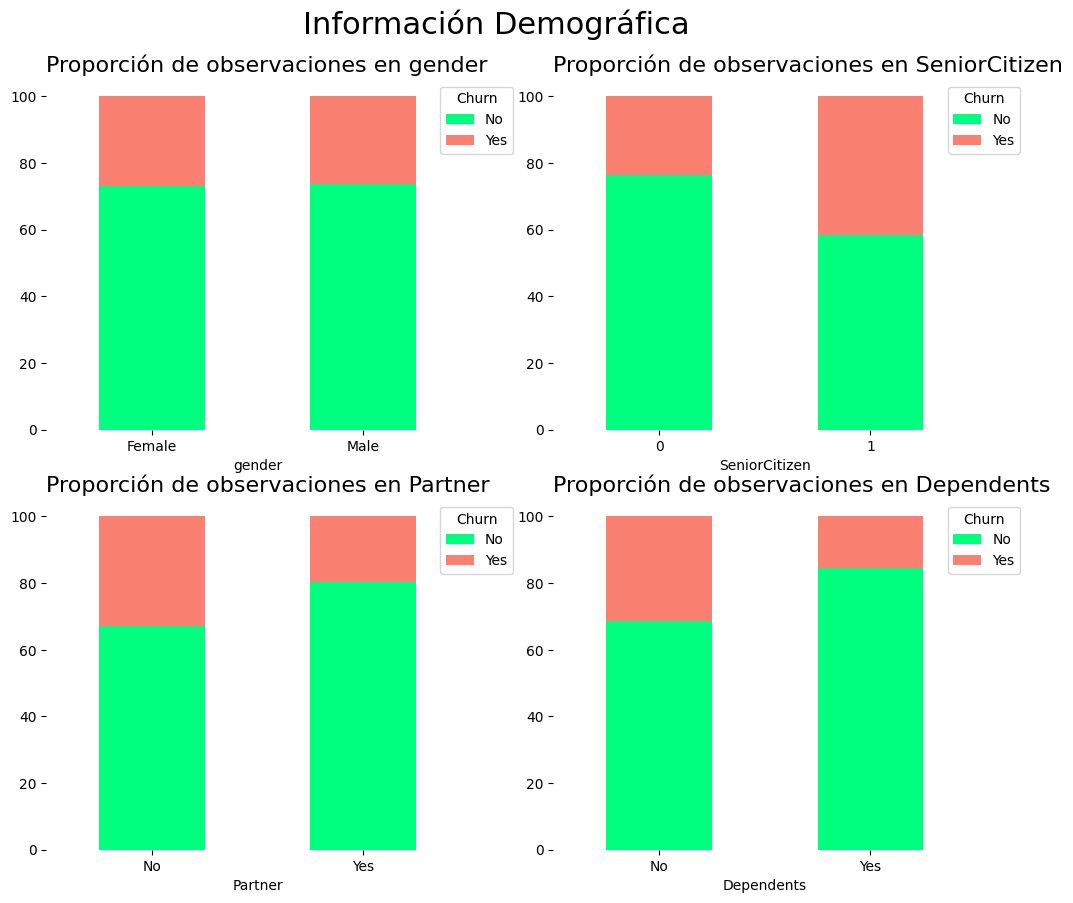

In [ ]:
# demographic column names
demographic_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Información Demográfica')

<h1>Conclusiones:</h1>

• La proporción de `Churn` para adultos mayores es casi el doble que para aquellos que no pertenecen a esta categoría.

• El género no parece tener impacto en la predicción del `Churn`. Tanto hombres como mujeres tienen similar proporción de Churners.

• La proporción de Churners es mayor en clientes sin pareja.

• La proporción de Churners es bastante mayor en clientes sin hijos.

<h1> Información Sobre la Cuenta del Cliente - Variables Categóricas</h1>

De la misma manera que hicimos con los atributos demográficos, evaluaremos la proporción de Churn para cada categoría de las características del cliente (`Contract`, `PaperlessBilling`, `PaymentMethod`).

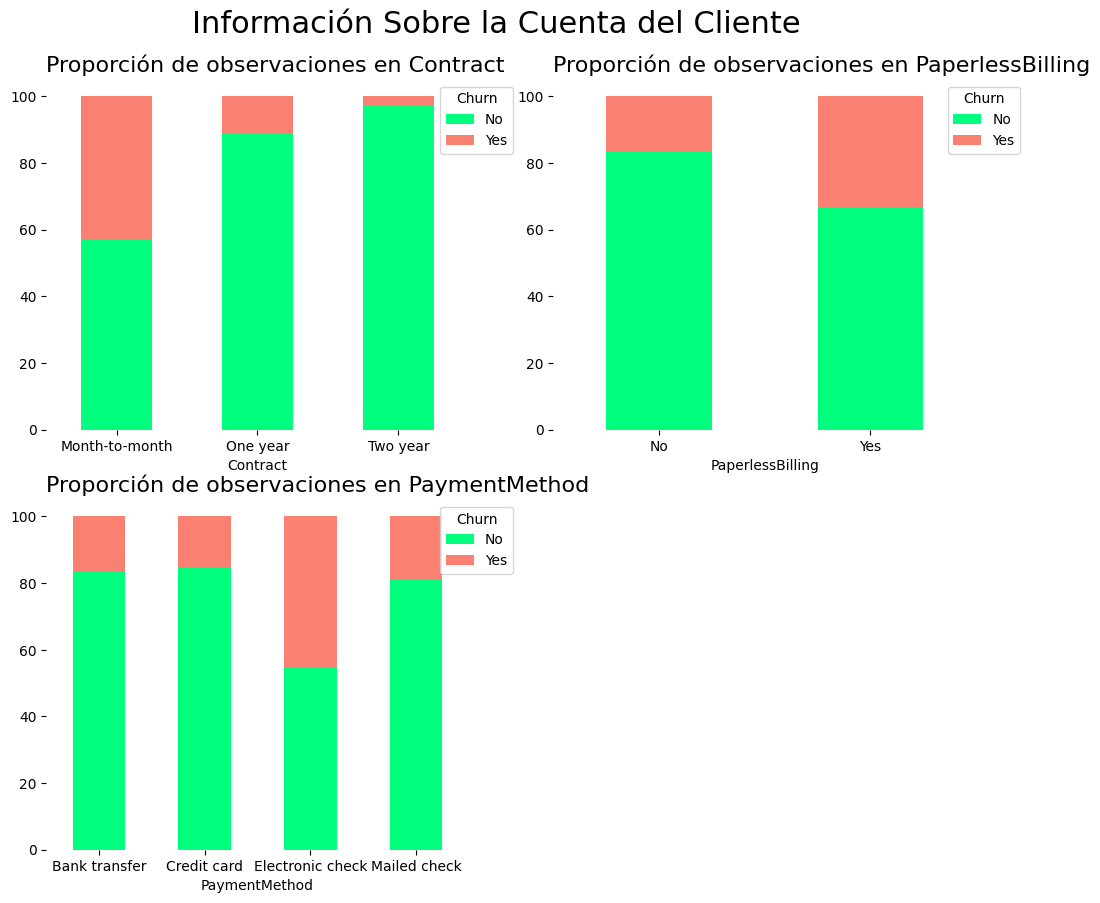

In [ ]:
# customer account column names
account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Información Sobre la Cuenta del Cliente')

<h1>Conclusiones:</h1>

• Los clientes con contratos mensuales tienen mayor proporción de `Churn` que aquellos con contratos anuales o bianuales.

• En cuanto a los métodos de pago, aquellos clientes que optaron por un cheque electrónico son bastante más propensos a Churnear que los demás métodos de pago.

• Los clientes que eligieron una facturación electrónica son más propensos a Churnear.

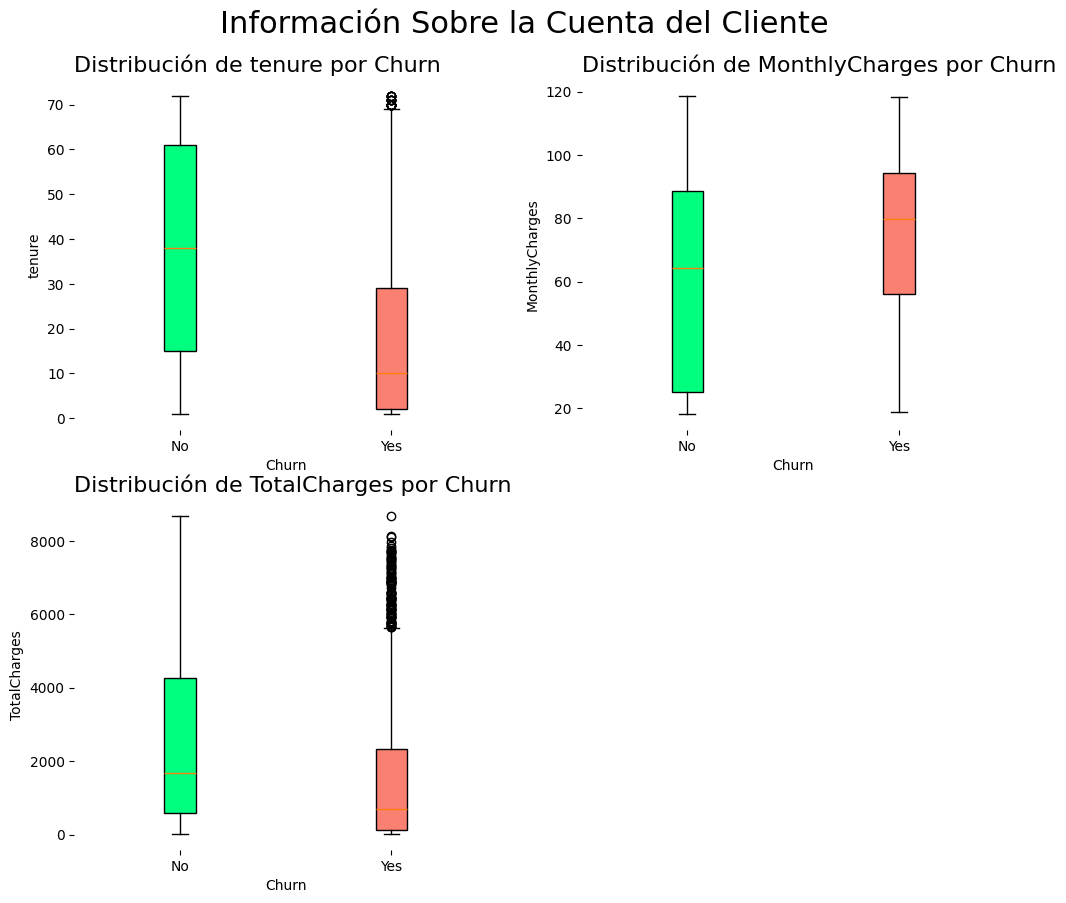

In [ ]:
def boxplot_plots(columns_to_plot, super_title):
    '''
    Prints boxplots for each independent variable of the list columns_to_plot,
    showing the distribution for each Churn category.

            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization

            Returns:
                    None
    '''
    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    fig.suptitle(super_title, fontsize=22, y=.95)

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # prepare data for boxplot
        data_no_churn = df_eda[df_eda['Churn']=='No'][column].dropna()
        data_yes_churn = df_eda[df_eda['Churn']=='Yes'][column].dropna()

        # create boxplots
        box_data = [data_no_churn, data_yes_churn]
        box_labels = ['No', 'Yes']

        # create the boxplot
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)

        # customize colors
        bp['boxes'][0].set_facecolor('springgreen')
        bp['boxes'][1].set_facecolor('salmon')
        # set title and labels
        ax.set_title('Distribución de ' + column + ' por Churn',
                     fontsize=16, loc='left')
        ax.set_xlabel('Churn')
        ax.set_ylabel(column)

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

# customer account column names
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
# boxplot of customer account columns
boxplot_plots(account_columns_numeric, 'Información Sobre la Cuenta del Cliente')

<h1>Conclusiones:</h1>

• En cuanto a los cargos mensuales, hay mayor acumulación de Churnerns en valores más altos.

• En clientes que Churnean, hay mayor acumulación de registros con poca antiguedad de contrato.

• Aquellos clientes que Churnean, suelen tener cargos totales más bajos. Esto podría producirse debido a la relación encontrada con `tenure` (menos meses de antiguedad, menos cargos totales).

In [ ]:
def calculate_statistical_measures(df, numeric_columns=None, group_by=None):
    '''
    Calcula las medidas estadísticas principales para variables numéricas.

    Parameters:
        df (DataFrame): DataFrame con los datos
        numeric_columns (list): Lista de columnas numéricas a analizar.
                               Si es None, detecta automáticamente.
        group_by (str): Columna para agrupar los análisis (ej: 'Churn')

    Returns:
        dict: Diccionario con DataFrames de estadísticas
    '''

    # Detectar columnas numéricas automáticamente si no se especifican
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    def compute_stats(data_series):
        """Función auxiliar para calcular estadísticas de una serie"""
        clean_data = data_series.dropna()

        if len(clean_data) == 0:
            return pd.Series([np.nan] * 20, index=[
                'count', 'mean', 'median', 'mode', 'std', 'var', 'min', 'max',
                'range', 'q1', 'q3', 'iqr', 'skewness', 'kurtosis',
                'cv', 'mad', 'sem', 'p10', 'p90', 'missing_count'
            ])

        # Medidas de tendencia central
        mean_val = clean_data.mean()
        median_val = clean_data.median()
        try:
            mode_val = clean_data.mode().iloc[0] if not clean_data.mode().empty else np.nan
        except:
            mode_val = np.nan

        # Medidas de dispersión
        std_val = clean_data.std()
        var_val = clean_data.var()
        min_val = clean_data.min()
        max_val = clean_data.max()
        range_val = max_val - min_val

        # Cuartiles y medidas de posición
        q1 = clean_data.quantile(0.25)
        q3 = clean_data.quantile(0.75)
        iqr = q3 - q1
        p10 = clean_data.quantile(0.10)
        p90 = clean_data.quantile(0.90)

        # Medidas de forma
        skewness_val = clean_data.skew()
        kurtosis_val = clean_data.kurtosis()

        # Otras medidas
        cv = (std_val / mean_val) * 100 if mean_val != 0 else np.nan  # Coeficiente de variación
        mad = np.mean(np.abs(clean_data - mean_val))  # Desviación absoluta media
        sem = stats.sem(clean_data)  # Error estándar de la media

        # Conteos
        count = len(clean_data)
        missing_count = len(data_series) - count

        return pd.Series([
            count, mean_val, median_val, mode_val, std_val, var_val,
            min_val, max_val, range_val, q1, q3, iqr, skewness_val,
            kurtosis_val, cv, mad, sem, p10, p90, missing_count
        ], index=[
            'count', 'mean', 'median', 'mode', 'std', 'var', 'min', 'max',
            'range', 'q1', 'q3', 'iqr', 'skewness', 'kurtosis',
            'cv', 'mad', 'sem', 'p10', 'p90', 'missing_count'
        ])

    results = {}

    if group_by is None:
        # Análisis general sin agrupamiento
        stats_df = pd.DataFrame()
        for col in numeric_columns:
            stats_df[col] = compute_stats(df[col])

        results['general_stats'] = stats_df.round(4)

    else:
        # Análisis agrupado
        if group_by not in df.columns:
            raise ValueError(f"La columna '{group_by}' no existe en el DataFrame")

        groups = df[group_by].unique()

        # Estadísticas por grupo
        for group in groups:
            group_data = df[df[group_by] == group]
            stats_df = pd.DataFrame()

            for col in numeric_columns:
                stats_df[col] = compute_stats(group_data[col])

            results[f'stats_{group}'] = stats_df.round(4)

        # Estadísticas generales también
        stats_df_general = pd.DataFrame()
        for col in numeric_columns:
            stats_df_general[col] = compute_stats(df[col])

        results['general_stats'] = stats_df_general.round(4)

        # Comparación entre grupos (diferencias)
        if len(groups) == 2:
            group1, group2 = groups
            comparison_df = pd.DataFrame()

            for col in numeric_columns:
                diff_series = results[f'stats_{group1}'][col] - results[f'stats_{group2}'][col]
                comparison_df[col] = diff_series

            results['comparison_diff'] = comparison_df.round(4)

    return results

def print_statistical_summary(results, title="Análisis Estadístico"):
    '''
    Imprime un resumen formateado de las estadísticas calculadas.

    Parameters:
        results (dict): Diccionario retornado por calculate_statistical_measures
        title (str): Título del reporte
    '''
    print("="*80)
    print(f"{title:^80}")
    print("="*80)

    # Definir descripciones de las métricas
    metric_descriptions = {
        'count': 'Cantidad de observaciones',
        'mean': 'Media aritmética',
        'median': 'Mediana (Q2)',
        'mode': 'Moda',
        'std': 'Desviación estándar',
        'var': 'Varianza',
        'min': 'Valor mínimo',
        'max': 'Valor máximo',
        'range': 'Rango (max - min)',
        'q1': 'Primer cuartil (Q1)',
        'q3': 'Tercer cuartil (Q3)',
        'iqr': 'Rango intercuartílico (Q3-Q1)',
        'skewness': 'Asimetría',
        'kurtosis': 'Curtosis',
        'cv': 'Coeficiente de variación (%)',
        'mad': 'Desviación absoluta media',
        'sem': 'Error estándar de la media',
        'p10': 'Percentil 10',
        'p90': 'Percentil 90',
        'missing_count': 'Valores faltantes'
    }

    for key, df in results.items():
        print(f"\n{key.replace('_', ' ').title()}:")
        print("-" * 60)

        # Mostrar DataFrame transpuesto para mejor lectura
        df_display = df.T

        # Añadir descripciones si es el primer DataFrame
        if 'general_stats' in key or 'stats_' in key:
            for idx in df_display.index:
                print(f"\n{idx}:")
                for col in df_display.columns:
                    desc = metric_descriptions.get(col, col)
                    value = df_display.loc[idx, col]
                    print(f"  {desc:<35}: {value}")
        else:
            print(df_display)

    print("\n" + "="*80)

# Ejemplo de uso:
# Análisis general
stats_results = calculate_statistical_measures(df_eda, account_columns_numeric)
print_statistical_summary(stats_results, "Estadísticas de Variables de Cuenta")

# Análisis agrupado por Churn
# stats_by_churn = calculate_statistical_measures(df_eda, account_columns_numeric, group_by='Churn')
# print_statistical_summary(stats_by_churn, "Estadísticas por Categoría de Churn")

                      Estadísticas de Variables de Cuenta                       

General Stats:
------------------------------------------------------------

tenure:
  Cantidad de observaciones          : 7032.0
  Media aritmética                   : 32.4218
  Mediana (Q2)                       : 29.0
  Moda                               : 1.0
  Desviación estándar                : 24.5453
  Varianza                           : 602.4698
  Valor mínimo                       : 1.0
  Valor máximo                       : 72.0
  Rango (max - min)                  : 71.0
  Primer cuartil (Q1)                : 9.0
  Tercer cuartil (Q3)                : 55.0
  Rango intercuartílico (Q3-Q1)      : 46.0
  Asimetría                          : 0.2377
  Curtosis                           : -1.3878
  Coeficiente de variación (%)       : 75.7061
  Desviación absoluta media          : 21.8602
  Error estándar de la media         : 0.2927
  Percentil 10                       : 2.0
  Percentil 90      

<h1>Análisis de los Resultados:</h1>

`TENURE` (Antiguedad en meses):

Distribución: Ligeramente asimétrica hacia la derecha (curtosis: 0.24)

Variabilidad: Muy alta (CV: 75.7%) - hay clientes muy nuevos y muy antiguos

Curtosis negativa (-1.39): Distribución más plana que la normal, sin concentración en el centro



`MONTHLY CHARGES` (Cargos mensuales):

Distribución: Ligeramente asimétrica hacia la izquierda (curtosis: -0.22)

Variabilidad: Moderada (CV: 46.4%)

Interpretación: La mediana ($70.35) es mayor que la media ($64.80), sugiere concentración en valores altos

Rango: De $18.25 a $118.75 - amplio espectro de planes



`TOTAL CHARGES` (Cargos totales):

Distribución: Fuertemente asimétrica hacia la derecha (curtosis: 0.96)

Variabilidad: Extremadamente alta (CV: 99.3%) - la más variable de las tres

Interpretación: Media ($2,283) muy superior a la mediana ($1,397) - muchos valores bajos y algunos muy altos



<h1>Correlación Lineal y No Lineal</h1>

Matriz de Correlación (Pearson):
                  tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.246862      0.825880
MonthlyCharges  0.246862        1.000000      0.651065
TotalCharges    0.825880        0.651065      1.000000


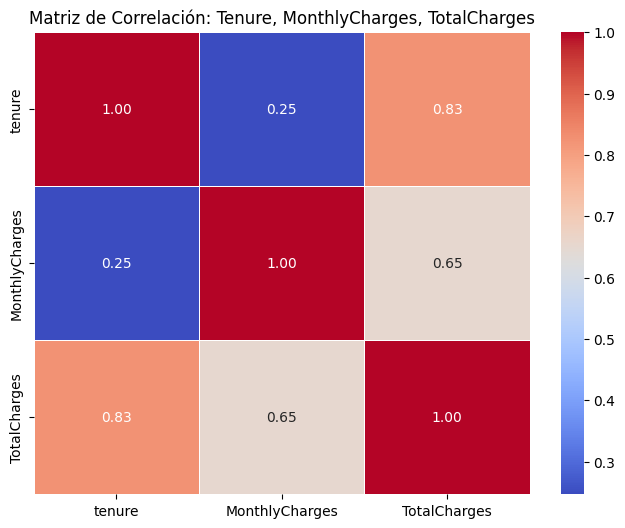

In [ ]:
# prompt: genera una matriz de correlacion entre las variables tenure, MonthlyCharges y TotalCharges

# Correlación entre tenure, MonthlyCharges y TotalCharges
correlation_matrix = df_eda[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(method='pearson')

# Imprimir la matriz de correlación
print("Matriz de Correlación (Pearson):")
print(correlation_matrix)

# Opcional: Visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación: Tenure, MonthlyCharges, TotalCharges')
plt.show()

<h1>Conclusión:</h1>

- Podemos observar una relación fuerte ente `tenure` y `TotalCharges`.

- Podemos observar una relación moderada entre `MonthlyCharges` y `TotalCharges`.

Para avanzar sobre el análisis de estas relaciones vamos a graficarlas.

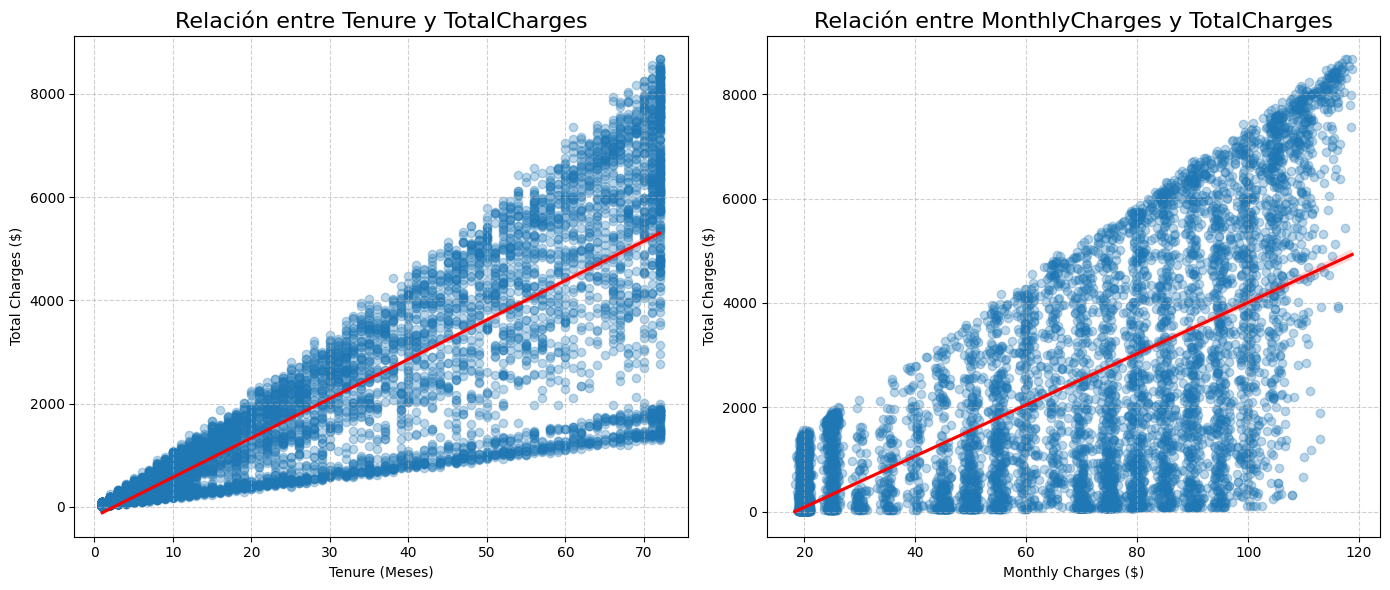

In [ ]:
# prompt: visualizar la relación entre tenure y TotalCharges, y entre MonthlyCharges y TotalCharges a traves de un scatterplot para cada una de las relaciones. añade la linea de tendencia en ambos graficos

# Crear scatterplots con línea de tendencia
plt.figure(figsize=(14, 6))

# Scatterplot para tenure vs TotalCharges
plt.subplot(1, 2, 1)
sns.regplot(x='tenure', y='TotalCharges', data=df_eda, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Relación entre Tenure y TotalCharges', fontsize=16)
plt.xlabel('Tenure (Meses)')
plt.ylabel('Total Charges ($)')
plt.grid(True, linestyle='--', alpha=0.6)

# Scatterplot para MonthlyCharges vs TotalCharges
plt.subplot(1, 2, 2)
sns.regplot(x='MonthlyCharges', y='TotalCharges', data=df_eda, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Relación entre MonthlyCharges y TotalCharges', fontsize=16)
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Total Charges ($)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

<h1>Conclusión:</h1>

Vemos en el primer gráfico la relación entre `tenure` y `TotalCharges`. Podemos observar una relación lineal fuerte positiva. Esto tiene sentido, ya que a medida que aumenta la antiguedad de un cliente, sus gastos totales en el servicio van a haber aumentado dado el paso del tiempo.

Por otro lado, podemos observar una relación similar entre MonthlyCharges y `TotalCharges`. También tiene un sentido lógico, ya que aquellos clientes que tienen mayores gastos mensuales, a lo largo del tiempo, tendrán un aún mayor gasto total.

# 🔎 Busqueda de Modelo Base

Para abordar la tarea de modelado de manera eficiente, iniciamos con una fase de 'búsqueda de modelo base'. El objetivo principal aquí es probar rápidamente diferentes tipos de modelos (como regresión logística, modelos basados en árboles, etc.) con configuraciones estándar. Esto nos ayuda a comprender qué familias de modelos tienen un rendimiento inicial aceptable sin invertir tiempo excesivo en la optimización individual de cada uno. Los modelos con mejor desempeño en esta etapa serán los que consideraremos para una optimización más profunda.

Sabiendo que hay modelos que necesitan estandarización, dividiremos esta busqueda en dos fases:
- Comparación rápida sin procesar -> Donde solo confiaremos en las métricas de los modelos de árboles
- Comparación con estandarización -> Usaremos la misma función pero solo con los modelos sensibles a las escalas y el data set previamente estandarizado

Por ultimo, compararemos resultados.

### 🔍 Fase 1 - Comparación rápida sin procesar

Creamos la función `evaluar_modelos()` que se utilizará para entrenar y evaluar varios modelos de clasificación de forma rápida. Como habiamos mencionado, el objetivo es obtener una primera idea de qué modelos podrían funcionar mejor para el problema dado, utilizando configuraciones predeterminadas o ajustes iniciales básicos.

In [ ]:
def evaluar_modelos(X_train, y_train, X_test, y_test):
    modelos = {
        #Estos son "tweaks iniciales seguros" que no se consideran tuning agresivo, sino buenas prácticas para establecer un baseline justo
        # 'Regresión Logística': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'HistGradientBoosting': HistGradientBoostingClassifier(),
        'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=2.773, use_label_encoder=False), #scale_pos_weight = 'Churn' 73.5% (yes) / 26.5% (no) = 2.773
        'LightGBM': LGBMClassifier(verbose=-1, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        # 'SVM_linear': SVC(kernel = 'linear', class_weight='balanced'),
        # 'SVM_rbf': SVC(kernel = 'rbf', class_weight='balanced')
    }

    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        # Asegurarse de que el modelo tiene el atributo predict_proba antes de usarlo
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        elif hasattr(modelo, "decision_function"):
            y_proba = modelo.decision_function(X_test)
        else:
            y_proba = None


        resultados.append({
            'Modelo': nombre,
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred), #Calcula el promedio de recall entre clases (recall clase 0 y clase 1).
            'F1 Score': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred), #Indica cuántos de los que realmente se fueron (churn=1) tu modelo detectó.
            'Precision': precision_score(y_test, y_pred),
            # 'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
            #PR AUC
            'PR AUC': average_precision_score(y_test,y_proba) if y_proba is not None else None #Es mejor que la ROC AUC para estos casos de desbalanceo
        })

    return pd.DataFrame(resultados).sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

Si bien la idea es probar los datos sin modificar tanto, los modelos a entrenar necesitan que estos se encuentren en un formato númerico.

Por esto, realizamos una codificación rápida correspondiente a cada variable, dado que tenemos muchas categóricas.

In [ ]:
# Eliminamos costumerID
df_inicial = df_mod.copy()
df_inicial.drop(columns='customerID', inplace=True)

# Realizamos modificaciones rapidas porque nuestros modelos necesitan variables numericas
binary_cols_quick = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# Variables categóricas con más de dos opciones (ajusta la lista si es necesario)
categorical_cols_quick = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                          'Contract', 'PaymentMethod']

# Aplicar codificación binaria a las columnas Yes/No
for col in binary_cols_quick:
    if col in df_inicial.columns:
        if df_inicial[col].dtype == 'object': # Solo codificar si son strings
             # Manejar el caso de 'No internet service' o 'No phone service' si aplica
            df_inicial[col] = df_inicial[col].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


# Aplicar One-Hot Encoding a las columnas con más de dos opciones
df_inicial = pd.get_dummies(df_inicial, columns=categorical_cols_quick, drop_first=True)

# Convertir las nuevas columnas booleanas a enteros (si pd.get_dummies las crea como bool)
bool_cols_quick = df_inicial.select_dtypes(include='bool').columns
df_inicial[bool_cols_quick] = df_inicial[bool_cols_quick].astype(int)

#Convertimos tambien la variable objetivo
df_inicial['Churn'] = df_inicial['Churn'].replace({'Yes': 1, 'No': 0})

# --- Fin de la codificación rápida ---




In [ ]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df_inicial.drop(columns = 'Churn'),
                                        df_inicial['Churn'],
                                        random_state = 22
                                    )

In [ ]:
# Evaluamos los modelos inciales
# ==============================================================================
df_resultados = evaluar_modelos(X_train, y_train, X_test, y_test)
df_resultados

,Modelo,Balanced Accuracy,F1 Score,Recall,Precision,PR AUC
0,LightGBM,0.742288,0.609756,0.697425,0.541667,0.652981
1,XGBoost,0.728270,0.594330,0.652361,0.545781,0.618629
2,HistGradientBoosting,0.699989,0.562500,0.502146,0.639344,0.651502
3,Random Forest,0.691248,0.548872,0.469957,0.659639,0.617921


Obtenemos un `df_resultados` con las metricas de cada modelo que más adelante analizamos bien.

###🔍 Fase 2 - Comparación con estandarización

Utilizamos el mismo split de datos de antes pero estandarizamos las variables numéricas.

In [ ]:
# Variables a escalar
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con datos de entrenamiento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Ajustamos la funcion `evaluar_modelos()` pero para entrenar solo los modelos que necesitan los valores estandarizados.

In [ ]:
def evaluar_modelos_estandarizados(X_train, y_train, X_test, y_test):
    modelos = {
        #Estos son "tweaks iniciales seguros" que no se consideran tuning agresivo, sino buenas prácticas para establecer un baseline justo
        'STD - Regresión Logística': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'STD - SVM_linear': SVC(kernel = 'linear', class_weight='balanced'),
        'STD - SVM_rbf': SVC(kernel = 'rbf', class_weight='balanced')
    }

    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        # Asegurarse de que el modelo tiene el atributo predict_proba antes de usarlo
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        elif hasattr(modelo, "decision_function"):
            y_proba = modelo.decision_function(X_test)
        else:
            y_proba = None


        resultados.append({
            'Modelo': nombre,
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred), #Calcula el promedio de recall entre clases (recall clase 0 y clase 1).
            'F1 Score': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred), #Indica cuántos de los que realmente se fueron (churn=1) tu modelo detectó.
            'Precision': precision_score(y_test, y_pred),
            # 'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
            #PR AUC
            'PR AUC': average_precision_score(y_test,y_proba) if y_proba is not None else None #Es mejor que la ROC AUC para estos casos de desbalanceo
        })

    return pd.DataFrame(resultados).sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
# Evaluamos los modelos estandarizados
# ==============================================================================
df_resultados_std = evaluar_modelos_estandarizados(X_train_scaled, y_train, X_test_scaled, y_test)
df_resultados_std

,Modelo,Balanced Accuracy,F1 Score,Recall,Precision,PR AUC
0,STD - Regresión Logística,0.761090,0.625756,0.776824,0.523878,0.645875
1,STD - SVM_rbf,0.755690,0.620932,0.757511,0.526080,0.592145
2,STD - SVM_linear,0.733419,0.587402,0.800429,0.463930,0.626465


In [ ]:
#Guardo los resultados en un pickle
with open('resultados_iniciales_estandarizados.pkl', 'wb') as f:
    pickle.dump(df_resultados_std, f)

---

###🟨 Comparación de resultados

In [ ]:
#Juntamos los resultados en un solo dataframe
df_resultados['Datos'] = 'Sin escalar'
df_resultados_std['Datos'] = 'Estandarizados'
df_todos = pd.concat([df_resultados, df_resultados_std], ignore_index=True)
df_todos_ordenado = df_todos.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

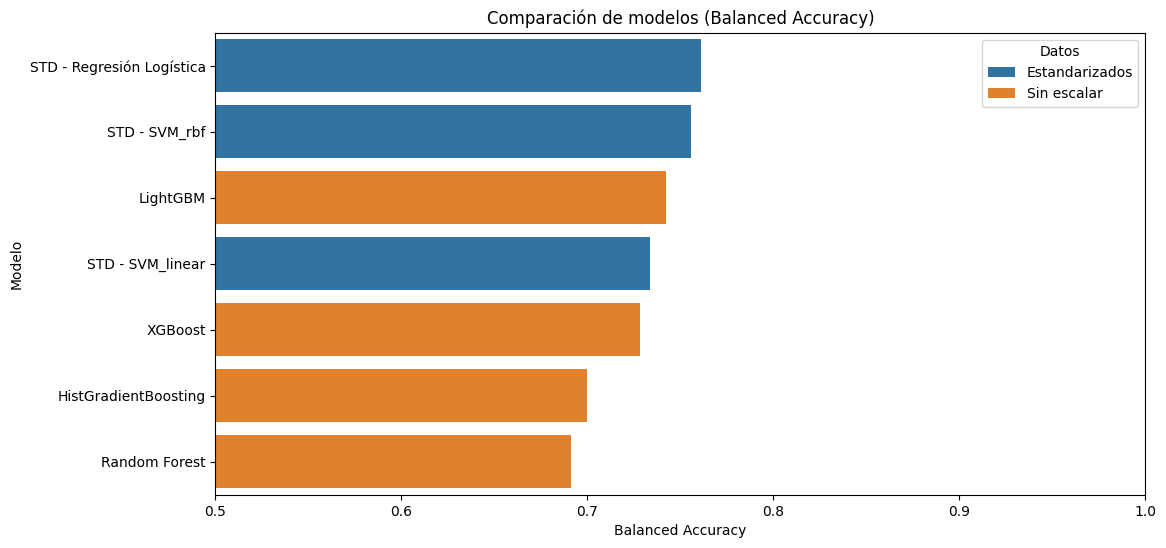

In [ ]:
#Mostramos un gráfico de barras con el balanced Accuracy de cada uno
plt.figure(figsize=(12, 6))
sns.barplot(data=df_todos_ordenado, x='Balanced Accuracy', y='Modelo', hue='Datos')
plt.title('Comparación de modelos (Balanced Accuracy)')
plt.xlim(0.5, 1.0)  # si querés limitar el eje x para enfocar
plt.show()


### Conclusión


* ✅ El modelo con mejor rendimiento general fue el `SVM_rbf` estandarizado, alcanzando la mayor Balanced Accuracy entre todos los modelos comparados.
* 🌳 El modelo `lightGBM` fue el que mejor accuracy tuvo de todos los árboles, teniendo casi el mismo valor que el SVM. Similar, solo por apenas debajo de este, se encuentra el de `Regresión Logística`. Ambos tambien podrían ser considerados como modelo final.
* ⚠️ El `SVM_linear` sin estandarizar puede no ser confiable, esto se debe a que luego de ser escalado, su accuracy es mucho menor, lo que nos hace pensar que en ese primer entrenamiento se vió sesgado por la escala de alguna variable.


Entonces, los modelos de
- `SVM_rbf`,
- `lightGBM`,
- `Regresión Logística`

son nuestros candidatos para ser usados en el proyecto.

Para terminar de decidirnos por uno, evaluaremos las demás métricas calculadas, con tal de ver cual es el que mejor se ajusta a nuestro problema.

Comparación de F1-Score y PR AUC para modelos seleccionados:
                      Modelo  F1 Score    PR AUC    Recall  Precision
0                   LightGBM  0.609756  0.652981  0.697425   0.541667
4  STD - Regresión Logística  0.625756  0.645875  0.776824   0.523878
5              STD - SVM_rbf  0.620932  0.592145  0.757511   0.526080


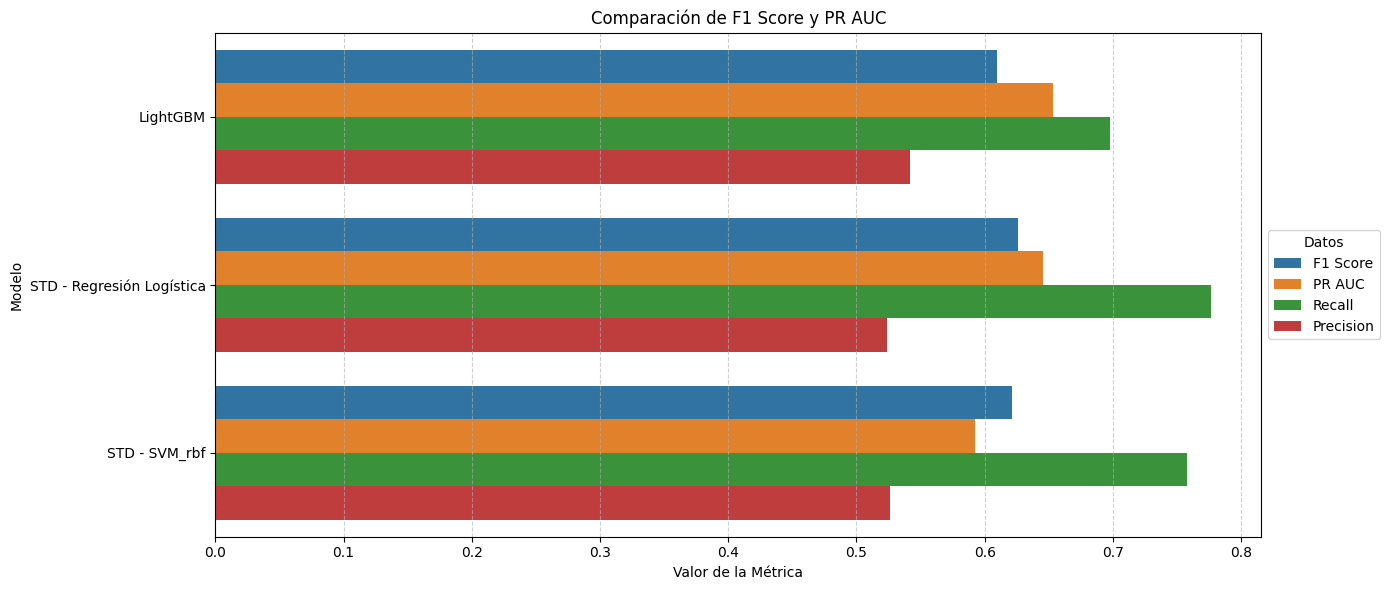

In [ ]:
# Armamos un gráfico comparativo con todas las demás métricas
#===============================================================================

# Filtramos los resultados para los modelos específicos a comparar
modelos_comparar = ['STD - SVM_rbf', 'LightGBM', 'STD - Regresión Logística']


# df_resultados['Datos'] = 'Sin escalar'
# df_resultados_std['Datos'] = 'Estandarizados'
df_todos = pd.concat([df_resultados, df_resultados_std], ignore_index=True)

# Filtramos el DataFrame combinado para incluir solo los modelos deseados
df_comparacion_especifica = df_todos[df_todos['Modelo'].isin(modelos_comparar)]

# Seleccionamos solo las columnas relevantes para la comparación de métricas
df_metricas_comparacion = df_comparacion_especifica[['Modelo', 'F1 Score', 'PR AUC','Recall','Precision']]

# Mostramos las métricas por pantalla
print("Comparación de F1-Score y PR AUC para modelos seleccionados:")
print(df_metricas_comparacion.sort_values(by='PR AUC', ascending=False))


# Visualizamos estas métricas en un gráfico
df_melted = df_metricas_comparacion.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df_melted, x='Valor', y='Modelo', hue='Métrica')
plt.title('Comparación de F1 Score y PR AUC')
plt.xlabel('Valor de la Métrica')
plt.ylabel('Modelo')
plt.grid(axis='x', linestyle='--', alpha=0.6)


ax.legend(title='Datos', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()


| Métrica                                       | ¿Qué mide?                                                                                       | ¿Por qué importa en tu caso?                                                                                            |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------- |
| **Balanced Accuracy**                         | Promedio de recall entre clase 0 y 1. No se deja engañar por el desbalance.                      | Te dice si el modelo aprende **ambas clases** en vez de acertar por casualidad.                                         |
| **Recall (o Sensibilidad)**                   | % de verdaderos positivos detectados. ¿Cuántos que realmente se fueron predijiste correctamente? | Es crítico: no querés dejar pasar clientes que se iban. Mejor tener falsos positivos que no detectarlos.                |
| **Precision**                                 | % de los que predijiste como "se va" que realmente se fueron.                                    | Complemento al recall. No querés alertar a todos si solo pocos se van.                                                  |
| **F1 Score**                                  | Promedio armonioso entre Precision y Recall.                                                     | Balance entre no asustar a todos y no perder a los que se iban.                                                         |
| **PR AUC (Área bajo curva Precision-Recall)** | Qué tan bien se comporta el modelo al clasificar la clase positiva.                              | Más útil que ROC AUC con clases desbalanceadas. Te da una idea del rendimiento **cuando te importa acertar positivos**. |


### Decisión final del modelo

Luego de evaluar distintos modelos, **decidimos seleccionar el `SVM_rbf`** como el más adecuado para nuestro objetivo principal: **minimizar la pérdida de clientes reales (churners)**. Es decir, priorizamos un **recall alto**, ya que preferimos contactar a clientes con riesgo de irse antes que dejar pasar casos reales de abandono.

Entre los modelos evaluados:

- La **regresión logística estandarizada** obtuvo el **mayor recall (0.764)** —proporción de churners correctamente identificados—, pero con una **precisión más baja (0.527)** —de todos los casos predichos como churn, cuántos realmente lo son—. Su **F1 Score** —promedio armónico entre precisión y recall— fue de **0.624**.

- El modelo **`SVM_rbf` estandarizado** logró un **recall muy similar (0.752)**, pero con una **mejor precisión (0.545)** y un **F1 Score superior (0.632)**. Esto indica que detecta casi los mismos casos de churn que la regresión logística, pero con **menos falsos positivos**, lo cual es clave si las acciones de retención tienen un costo.

- Por otro lado, **`LightGBM`** presentó la **mayor precisión (0.569)**, pero con un **recall más bajo (0.717)**. Esto implica que, si bien acierta más en sus predicciones positivas, **deja pasar más casos reales de churn**, lo que no se alinea con nuestra prioridad. Su F1 Score fue de **0.635**.

En resumen, el modelo **`SVM_rbf` logra un mejor equilibrio**, manteniendo un recall alto (detectamos la mayoría de los que se van), sin sacrificar tanto la precisión (no sobreactuamos en exceso), y superando a la regresión logística en F1 Score. Por estos motivos, consideramos que es la mejor elección para nuestro caso.


<hr>

---

#🛠️ Preparación de los datos para el modelo elegido

Habiendo elegido el modelo `SVM_rbf`, es necesario realizar una preparación de datos más detallada. Esto implica un manejo cuidadoso de la redundancia en las variables categóricas, su posterior codificación numérica y la estandarización de las características para asegurar el mejor rendimiento del modelo.

<b><h3>Manejo de Redundancia en variables categóricas<h3>

Debido a como está estructurada la base de datos, podemos decir que existe una redundancia de información en ciertas variables categóricas, principalmente en aquellas que hablan sobre el uso de ciertos servicios los cuales dependen de un servicio "general".

Para solucionar esto, decidimos transformar estas variables categóricas con múltiples opciones. Por ejemplo, `MultipleLines` a binario, ya que si un cliente no tiene Servicio Telefónico, no tendrá Múltiples Lineas.

<h3></h3>

Si la fila tiene Phone Service == 1 y Multiple Lines == 1, le asigna un 1 en la nueva columna. En caso de no tener Phone Service, o de no tener Multiple Lines, le asigna un 0. Luego, elimina la columna original.

In [ ]:
df_mod_1 = df_mod.copy()
df_mod_1['HasMultipleLines'] = ((df_mod_1['PhoneService'] == 1) & (df_mod_1['MultipleLines'] == 'Yes')).astype(int)
df_mod_1.drop(columns='MultipleLines', inplace=True)

Volvemos a realizar la misma transformación para aquellas variables que "dependen" de Internet Service.



In [ ]:
df_mod_2 = df_mod_1.copy()
# Lista de columnas relacionadas con servicios que dependen de tener Internet
internet_services = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Creamos nuevas variables binarias
for col in internet_services:
    new_col = 'Has' + col  # Ej: 'HasOnlineSecurity'
    df_mod_2[new_col] = ((df_mod_2['InternetService'] != 'No') & (df_mod_2[col] == 'Yes')).astype(int)

# Eliminamos columnas originales
df_mod_2.drop(columns=internet_services, inplace=True)

<b><h3>Transformación de datos<h3>

[Se aplica el binary encoding a las variables binarias recien modificadas...]

In [ ]:
# Transformamos variables categóricas de 3 o más opciones con el método dummy coding.
df_mod_3 = df_mod_2.copy()

# Lista de columnas categóricas a codificar
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']

# Aplicamos One-Hot Encoding
df_mod_3 = pd.get_dummies(df_mod_3, columns=categorical_cols, drop_first=True)

[...]

In [ ]:
# Todas las nuevas columnas creadas por el dummy coding son booleanas, las transformamos a numéricas
df_mod_4 = df_mod_3.copy()
bool_cols = df_mod_4.select_dtypes(include='bool').columns
df_mod_4[bool_cols] = df_mod_4[bool_cols].astype(int)

[...]

In [ ]:
# Reemplazo específico para 'gender'
df_mod_5 = df_mod_4.copy()
df_mod_5['gender'] = df_mod_5['gender'].replace({'Male': 1, 'Female': 0})

# Otras variables categóricas binarias (Yes/No)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','Churn']
df_mod_5[binary_cols] = df_mod_5[binary_cols].replace({'Yes': 1, 'No': 0})

[...Comentario sobre el creado de nuevas variables...]

In [ ]:
# Eliminamos costumerID
df_final = df_mod_5.copy()
df_final.drop(columns='customerID', inplace=True)

<b><h3>División de Datos<h3>


Antes de aplicar cualquier transformación, debemos dividir los datos en `training` y `testing` sets para evitar un **Data Leakage**.





In [ ]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df_final.drop(columns = 'Churn'),
                                        df_final['Churn'],
                                        random_state = 22
                                    )

<b><h3>Estandarización de Datos<h3>

[...]

In [ ]:
# Variables a escalar
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Inicializamos el escalador
scaler = StandardScaler()

# Ajustamos el escalador solo con datos de entrenamiento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Finalmente, tenemos los datos limpios, estandarizados y divididos, listos para ser usados en el entrenamiento del modelo elegido.

#🧠 Entrenamiento del modelo

Ya estamos en condiciones de optimizar el modelo elegido con el propósito de mejorar aún más esas mérticas iniciales obtenidas.

Para esto, arrancaremos con ... [Grid search y CV ?]

In [ ]:
df_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,HasTechSupport,HasStreamingTV,HasStreamingMovies,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, make_scorer # Import make_scorer
from sklearn.model_selection import StratifiedKFold


In [ ]:
# Espacio de hiperparámetros para Grid Search y Random Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced'] # Mantener el class_weight que usaste antes
}
scorer = make_scorer(balanced_accuracy_score)


# Para Randomized Search, puedes definir distribuciones o listas
param_distributions = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced']
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds, shuffle=True (buena práctica), random_state para reproducibilidad


In [ ]:
# Inicializar el modelo SVM
svm_rbf = SVC(kernel='rbf', probability=True) # probability=True para poder obtener predict_proba

# Configurar Grid Search
grid_search = GridSearchCV(estimator=svm_rbf,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=kf, # Usar validación cruzada con 5 folds
                           n_jobs=-1) # Usar todos los cores disponibles

# Ejecutar Grid Search (esto puede tardar)
print("Iniciando Grid Search...")
grid_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros y la mejor puntuación
print("Mejores hiperparámetros encontrados (Grid Search):")
print(grid_search.best_params_)
print("Mejor Balanced Accuracy (Grid Search):")
print(grid_search.best_score_)

# Obtener el mejor modelo encontrado por Grid Search
best_svm_grid = grid_search.best_estimator_

Iniciando Grid Search...
Mejores hiperparámetros encontrados (Grid Search):
{'C': 10, 'class_weight': 'balanced', 'gamma': 0.001}
Mejor Balanced Accuracy (Grid Search):
0.7639175721527399


In [ ]:
# Configurar Random Search
random_search = RandomizedSearchCV(estimator=svm_rbf,
                                   param_distributions=param_distributions,
                                   n_iter=20, # Número de combinaciones aleatorias a probar
                                   scoring=scorer,
                                   cv=kf,
                                   random_state=42, # Para reproducibilidad
                                   n_jobs=-1)

# Ejecutar Random Search (esto puede ser más rápido que Grid Search)
print("\nIniciando Random Search...")
random_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros y la mejor puntuación
print("Mejores hiperparámetros encontrados (Random Search):")
print(random_search.best_params_)
print("Mejor Balanced Accuracy (Random Search):")
print(random_search.best_score_)

# Obtener el mejor modelo encontrado por Random Search
best_svm_random = random_search.best_estimator_


Iniciando Random Search...
Mejores hiperparámetros encontrados (Random Search):
{'gamma': 0.001, 'class_weight': 'balanced', 'C': 10}
Mejor Balanced Accuracy (Random Search):
0.7639175721527399


In [ ]:
# Evaluar el mejor modelo de Grid Search en el conjunto de prueba
y_pred_grid = best_svm_grid.predict(X_test_scaled)
print("\nMétricas del mejor modelo (Grid Search) en el conjunto de prueba:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_grid)}")
print(f"F1 Score: {f1_score(y_test, y_pred_grid)}")
print(f"Recall: {recall_score(y_test, y_pred_grid)}")
print(f"Precision: {precision_score(y_test, y_pred_grid)}")

# Si el modelo tiene predict_proba o decision_function
if hasattr(best_svm_grid, "predict_proba"):
    y_proba_grid = best_svm_grid.predict_proba(X_test_scaled)[:, 1]
    print(f"PR AUC: {average_precision_score(y_test, y_proba_grid)}")
elif hasattr(best_svm_grid, "decision_function"):
    y_proba_grid = best_svm_grid.decision_function(X_test_scaled)
    print(f"PR AUC: {average_precision_score(y_test, y_proba_grid)}")


# Evaluar el mejor modelo de Random Search en el conjunto de prueba
y_pred_random = best_svm_random.predict(X_test_scaled)
print("\nMétricas del mejor modelo (Random Search) en el conjunto de prueba:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_random)}")
print(f"F1 Score: {f1_score(y_test, y_pred_random)}")
print(f"Recall: {recall_score(y_test, y_pred_random)}")
print(f"Precision: {precision_score(y_test, y_pred_random)}")

# Si el modelo tiene predict_proba o decision_function
if hasattr(best_svm_random, "predict_proba"):
    y_proba_random = best_svm_random.predict_proba(X_test_scaled)[:, 1]
    print(f"PR AUC: {average_precision_score(y_test, y_proba_random)}")
elif hasattr(best_svm_random, "decision_function"):
    y_proba_random = best_svm_random.decision_function(X_test_scaled)
    print(f"PR AUC: {average_precision_score(y_test, y_proba_random)}")


Métricas del mejor modelo (Grid Search) en el conjunto de prueba:
Balanced Accuracy: 0.7495681579611742
F1 Score: 0.610312764158918
Recall: 0.7746781115879828
Precision: 0.5034867503486751
PR AUC: 0.6432307609306871

Métricas del mejor modelo (Random Search) en el conjunto de prueba:
Balanced Accuracy: 0.7495681579611742
F1 Score: 0.610312764158918
Recall: 0.7746781115879828
Precision: 0.5034867503486751
PR AUC: 0.6432307609306871


###Grid Search basado en validación cruzada

In [ ]:
#Grid Search...

#🔮 Predicción y Evaluación del modelo

En esta sección vamos a mostrar el resultado final luego de entrenar nuestro modelo optimizado de `SVM` analizando todas sus métricas resultantes y comparando si hubo una mejora, o no, respecto al primer entrenamiento hecho.

###Predicción de Probabilidades

In [ ]:
#...

###Importancia de Predictores

In [ ]:
#...

#✅ Conclusión Final

*Conclusion final sobre el modelo elegido, sus metricas , demas*

*Una conclusión mas relacionada al contexto del problema; como usar este modelo, ...*

*Identificar debilidades? Seguramente tenga que ver con los falsos positivos*

*Hablar sobre si habrá alguna forma de mejorarlo, mas datos, otros modelos, feature engineering, usar varios modelos a la vez...*

---